In [1]:
import pandas as pd
import numpy as np
import sqlite3
import sqlalchemy as sqa
from scipy import stats
import plotly_express as px
from lib.helper import Db, lmplot

In [2]:
import seaborn as sns

In [3]:
sns.set()

# Import Tables

In [4]:
base_path = ''
db_file = f'{base_path}db/ussc.db'
db = Db(db_file)
OHCO = ['vol_num','case_num','position']

In [5]:
db.list_tables_in_db()

['AUTHOR',
 'BOW',
 'CASE',
 'CORPUS',
 'CORPUS_COMPRESSED',
 'D2V',
 'D2VP',
 'PHI',
 'PHI_NMF',
 'THETA',
 'THETA_NMF',
 'TOPICS',
 'TOPICS_NMF',
 'VOCAB',
 'YEAR']

In [6]:
db.import_table('CASE', OHCO[:2])
db.import_table('THETA', OHCO)
db.import_table('TOPICS', 'topic_id')
db.n_topics = db.TOPICS.shape[0]

In [7]:
db.n_topics

40

# Sort Topics by Doc Weight

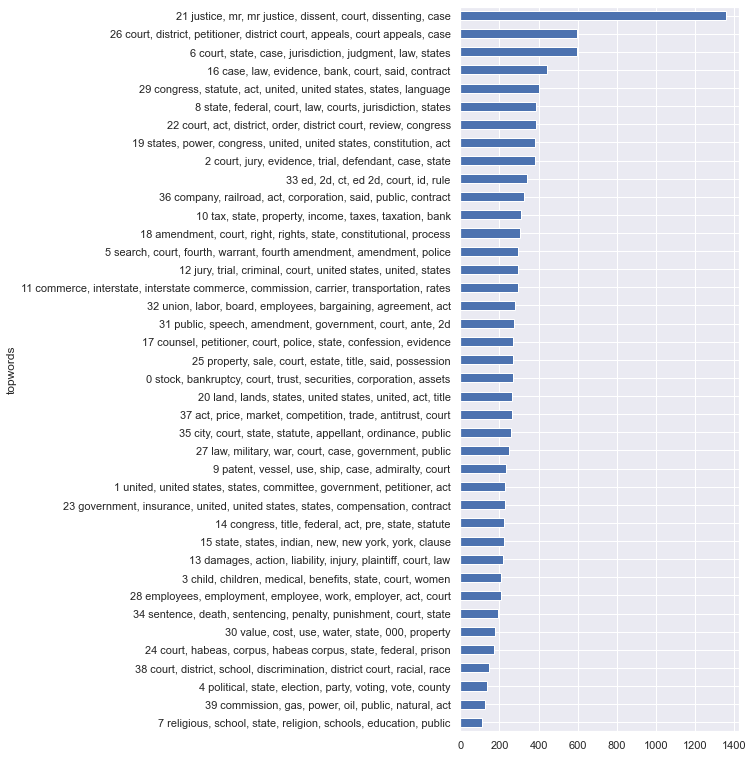

In [8]:
db.TOPICS.sort_values('doc_weight_sum', ascending=True)\
    .plot.barh(y='doc_weight_sum', x='topwords', figsize=(5, db.n_topics/3), legend=False);

# Topic Pair Distances

In [9]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [10]:
SIMS = pdist(normalize(db.THETA.T), metric='cosine')

# Draw HAC Tree

In [11]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, db.n_topics / 3))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [12]:
TREE = sch.linkage(SIMS, method='ward')

<Figure size 432x288 with 0 Axes>

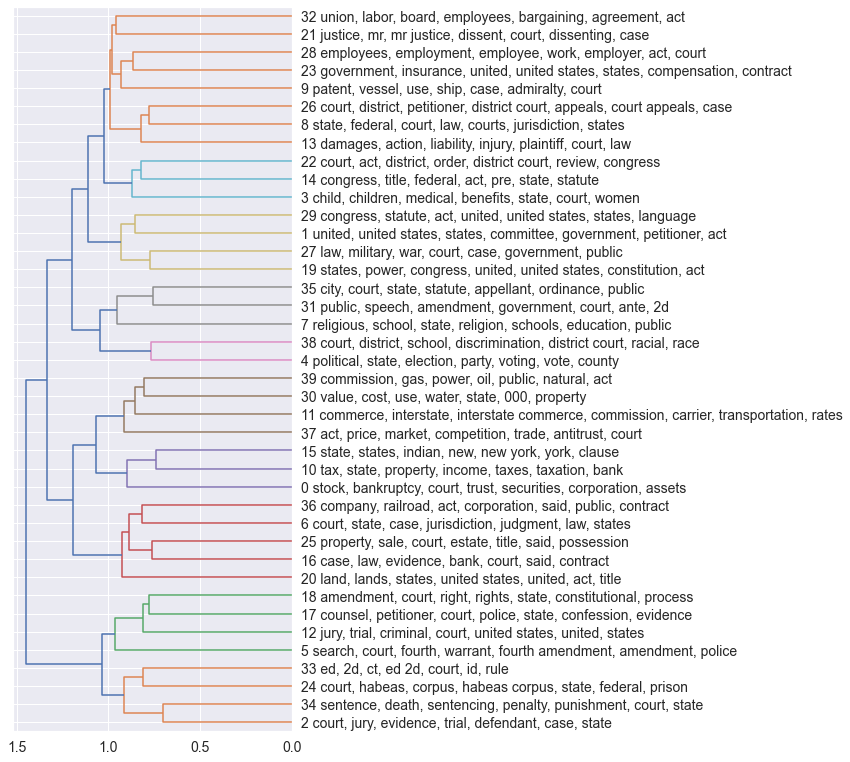

In [13]:
plot_tree(TREE, db.TOPICS.topwords.to_list());

# Square Matrix of Distances

In [14]:
TDIST = pd.DataFrame(squareform(SIMS)).stack().to_frame('dist')
TDIST.index.names = ['topic_a','topic_b']

In [15]:
TDIST.sort_values('dist', ascending=False).head(10)

dist
topic_a topic_b          
9       7        0.998459
7       9        0.998459
24      37       0.997955
37      24       0.997955
4       9        0.997153
9       4        0.997153
11      24       0.996732
24      11       0.996732
36      24       0.996620
24      36       0.996620

# Get Top Topics for Each Opinion  $X$

## Remove Most Frequent Topic

In [16]:
idx = [str(t) for t in (set(db.TOPICS.index.tolist()) - {21})]

In [17]:
X = db.THETA[idx].idxmax(1).to_frame('max_topic_id').sort_index()
X.max_topic_id = X.max_topic_id.astype('int')

In [18]:
X['topwords'] = X.max_topic_id.map(db.TOPICS.topwords)

In [19]:
X.head(10)

max_topic_id  \
vol_num case_num position                 
3       171      dissent              6   
                 opinion             10   
        321      dissent              6   
                 opinion             16   
        386      dissent             19   
                 opinion             19   
6       358      dissent             19   
                 opinion             19   
7       300      dissent             16   
                 opinion             16   

                                                                    topwords  
vol_num case_num position                                                     
3       171      dissent   6 court, state, case, jurisdiction, judgment, ...  
                 opinion   10 tax, state, property, income, taxes, taxati...  
        321      dissent   6 court, state, case, jurisdiction, judgment, ...  
                 opinion   16 case, law, evidence, bank, court, said, con...  
        386      dissent   19 states, power, congress, united, united sta...  
                 opinion   19 states, power, congress, united, united sta...  
6       358      dissent   19 states, power, congress, united, united sta...  
                 opinion   19 states, power, congress, united, united sta...  
7       300      dissent   16 case, law, evidence, bank, court, said, con...  
                 opinion   16 case, law, evidence, bank, court, said, con...

# Unstack $X$ &rarr; $X1$

In [20]:
X1 = X.max_topic_id.unstack().sort_index()
X1['test'] = X1.dissent != X1.opinion
X1.test = X1.test.astype('int')
X1 = X1.rename(columns={'dissent':'dissent_topic', 'opinion':'opinion_topic'})

In [21]:
X1.head()

position          dissent_topic  opinion_topic  test
vol_num case_num                                    
3       171                   6             10     1
        321                   6             16     1
        386                  19             19     0
6       358                  19             19     0
7       300                  16             16     0

# Add Top Topic Distances

In [22]:
X1['topic_dist'] = X1.apply(lambda x: TDIST.loc[x.dissent_topic, x.opinion_topic], 1)

<AxesSubplot:ylabel='Frequency'>

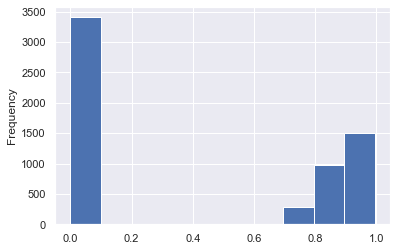

In [23]:
X1.topic_dist.sort_values().plot.hist()

## Add Year to $X1$

In [24]:
try:
    X1 = X1.join(db.CASE.year)
except:
    pass

# Mean Topic Distance per Year $X2$

In [25]:
X1.head()

dissent_topic  opinion_topic  test  topic_dist  year
vol_num case_num                                                      
3       171                   6             10     1    0.912265  1796
        321                   6             16     1    0.828405  1796
        386                  19             19     0    0.000000  1798
6       358                  19             19     0    0.000000  1805
7       300                  16             16     0    0.000000  1806

In [26]:
X2 = X1.groupby('year').topic_dist.mean().to_frame('mean_dist')

In [27]:
X2.head()

mean_dist
year           
1789   0.000000
1796   0.870335
1798   0.000000
1805   0.000000
1806   0.000000

# Consider only 20th Century $X3$

In [28]:
X3 = X2.loc[X2.index >= 1900]

In [29]:
X3.head()

mean_dist
year           
1900   0.667069
1901   0.600627
1902   0.653954
1903   0.679262
1904   0.597141

# Plot of $X3$

In [76]:
P = lmplot(X3.reset_index()).set_x('year').set_y('mean_dist')

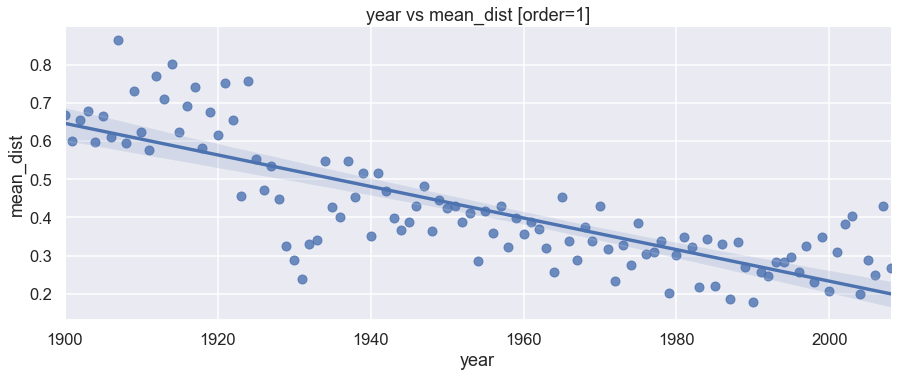

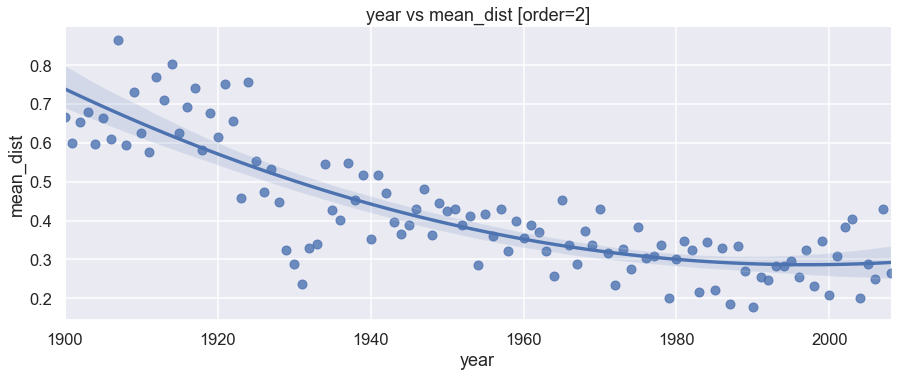

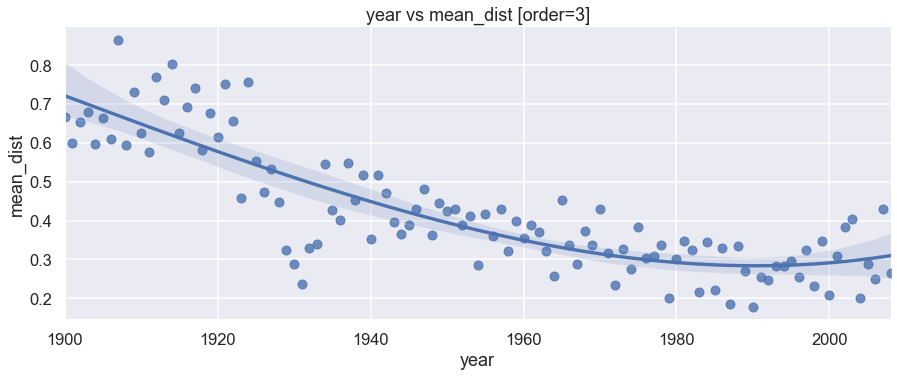

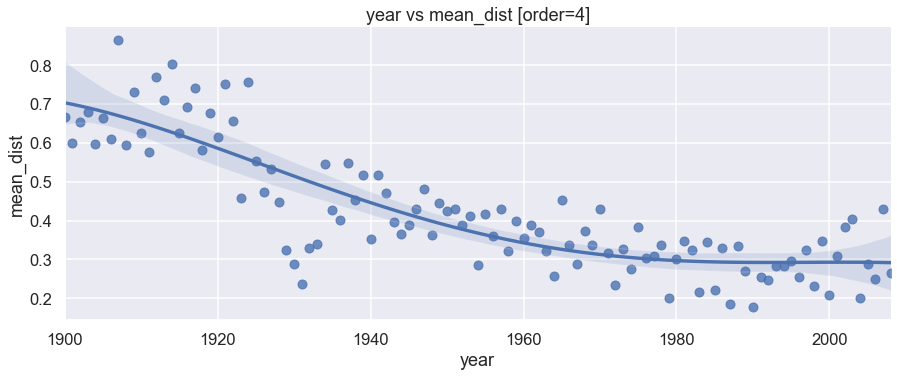

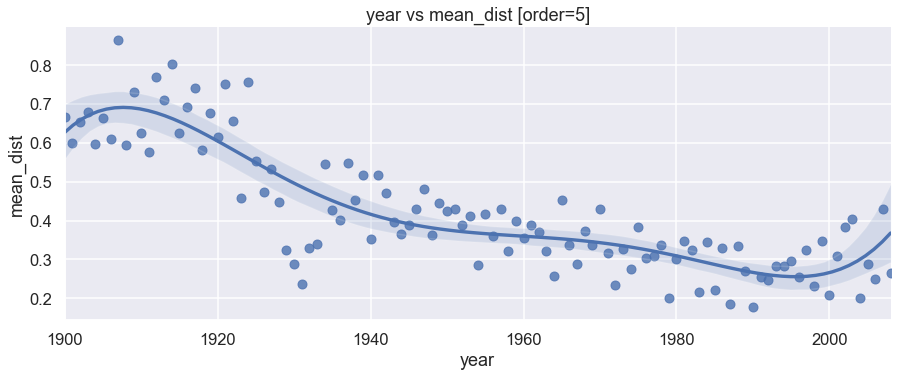

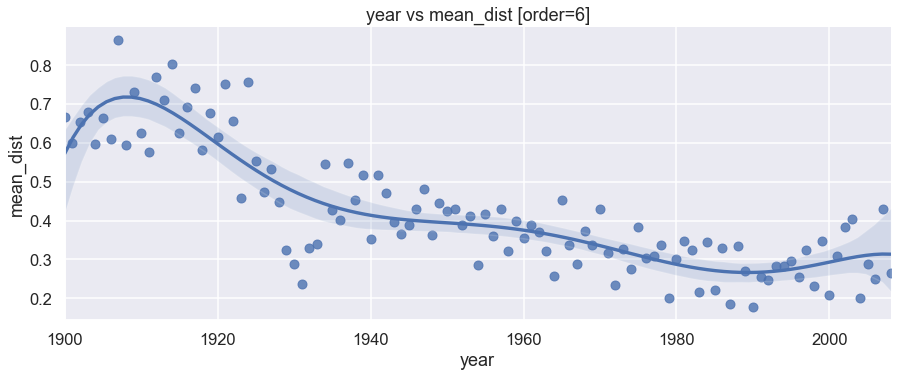

In [77]:
for order in range(1,7):
    P.set_order(order)
    P.plot()

# Predict

In [78]:
x = [1900 + i for i in range(X3.shape[0])]
y = X3.mean_dist.tolist()
domain = [X3.index[0], X3.index[-1]]
max_order = 6

In [79]:
P = pd.DataFrame([np.polynomial.Polynomial.fit(x, y, i).convert() for i in range(max_order+1)]).fillna(0)

In [80]:
P

0             1            2             3             4  \
0  4.229563e-01  0.000000e+00     0.000000  0.000000e+00  0.000000e+00   
1  8.497968e+00 -4.132555e-03     0.000000  0.000000e+00  0.000000e+00   
2  1.918244e+02 -1.918234e-01     0.000048  0.000000e+00  0.000000e+00   
3 -1.949767e+03  3.097211e+00    -0.001635  2.871875e-07  0.000000e+00   
4 -1.457148e+05  2.974942e+02    -0.227681  7.741820e-05 -9.868349e-09   
5 -4.100060e+07  1.048753e+05  -107.295167  5.488089e-02 -1.403449e-05   
6 -2.066224e+09  6.325775e+06 -8068.731038  5.488606e+00 -2.099945e-03   

              5             6  
0  0.000000e+00  0.000000e+00  
1  0.000000e+00  0.000000e+00  
2  0.000000e+00  0.000000e+00  
3  0.000000e+00  0.000000e+00  
4  0.000000e+00  0.000000e+00  
5  1.435478e-09  0.000000e+00  
6  4.284689e-07 -3.642387e-11

In [81]:
def predict(x, order=1):
    global P
    y = (P.loc[order] * pd.Series([x**z for z in range(order+1)])).sum()
    return y

In [82]:
xt = 2021

In [83]:
predict(xt, 3)

0.3662135597096494

# Case Topics over Time $X4$

In [84]:
X4 = db.CASE.join(X1[['dissent_topic','opinion_topic','topic_dist']])\
    [['year', 'dissent_topic', 'opinion_topic', 'topic_dist']]\
    .reset_index().drop_duplicates()
X4 = X4.reset_index(drop=True).set_index(['vol_num', 'case_num', 'year']).sort_index()

In [85]:
X4

dissent_topic  opinion_topic  topic_dist
vol_num case_num year                                          
3       1        1794            NaN            NaN         NaN
        6        1794            NaN            NaN         NaN
        17       1795            NaN            NaN         NaN
        121      1795            NaN            NaN         NaN
        171      1796            6.0           10.0    0.912265
...                              ...            ...         ...
554     407      2008           34.0           34.0    0.000000
        471      2008           13.0           13.0    0.000000
        527      2008           39.0           39.0    0.000000
        570      2008           31.0           27.0    0.888766
        724      2008            NaN            NaN         NaN

[22102 rows x 3 columns]

## Dissenting and Opinion Topic Heatmaps $X5$ $X6$

In [86]:
X5 = X4.groupby(['year','dissent_topic']).dissent_topic.count().to_frame().unstack().fillna(0)
X5.columns = X5.columns.droplevel(0)
X5 = X5.astype('int')

In [87]:
X6 = X4.groupby(['year','opinion_topic']).dissent_topic.count().to_frame().unstack().fillna(0)
X6.columns = X6.columns.droplevel(0)
X6 = X6.astype('int')

In [88]:
# X5.tail(30).T.style.background_gradient(cmap='YlGnBu')

In [89]:
# X6.tail(30).T.style.background_gradient(cmap='YlGnBu')

## Dot Prodict of $X5$ abd $X6$ $= X7$

In [90]:
X7 = X5.T.dot(X6)

In [91]:
# X7.style.background_gradient(cmap='YlGnBu', axis=1)

## Bar Charts per Topic $X8$

In [92]:
opinion = X6.stack().to_frame('n')
opinion['type'] = 'opinion'
dissent = X5.stack().to_frame('n')
dissent['type'] = 'dissent'
X8 = pd.concat([opinion, dissent]).reset_index()
X8.columns = ['year', 'topic_id', 'n', 'type']
X8.topic_id = X8.topic_id.astype('int')

In [93]:
X8

year  topic_id  n     type
0      1789         0  0  opinion
1      1789         1  0  opinion
2      1789         2  0  opinion
3      1789         3  0  opinion
4      1789         4  0  opinion
...     ...       ... ..      ...
14347  2008        35  0  dissent
14348  2008        36  0  dissent
14349  2008        37  0  dissent
14350  2008        38  0  dissent
14351  2008        39  1  dissent

[14352 rows x 4 columns]

In [94]:
X9 = X8.groupby(['year', 'topic_id']).n.sum().to_frame('n').unstack()

In [95]:
# X9

In [96]:
X10 = (X9.T / X9.T.sum()).T
X10.columns = X10.columns.droplevel(0)
X10 = X10.stack().to_frame('p').reset_index()

In [97]:
X10.head()

year  topic_id    p
0  1789         0  0.0
1  1789         1  0.0
2  1789         2  0.0
3  1789         3  0.0
4  1789         4  0.0

In [98]:
def plot_topic_over_years(tn, start_year=1900):
    global X10
    title = 'Topic ' + db.TOPICS.loc[tn].topwords    
    i = px.bar(X10[(X10.year >= start_year) & (X10.topic_id == tn)], x='year', y='p', title=title)
    i.show()

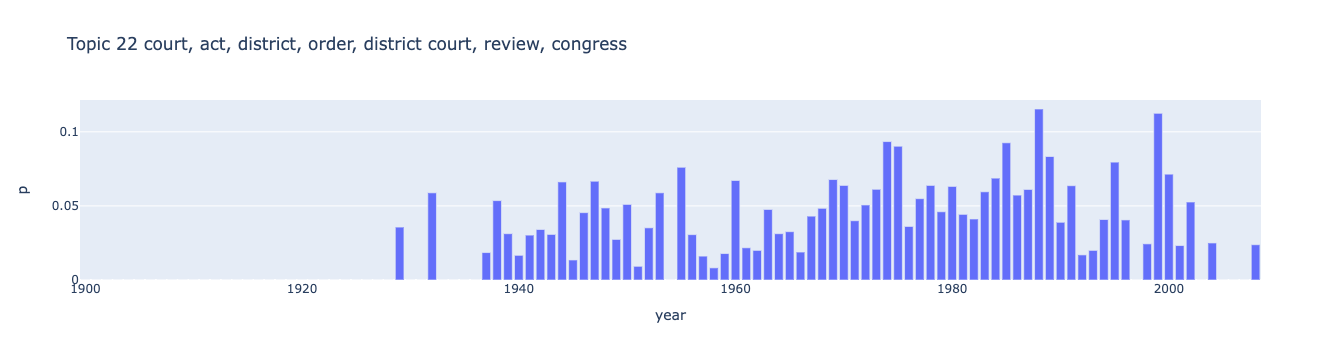

In [99]:
plot_topic_over_years(22)

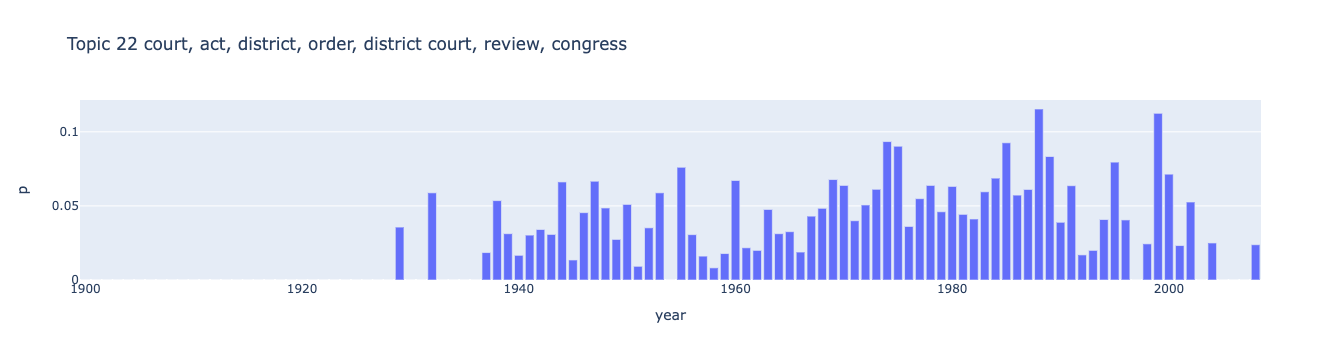

In [100]:
plot_topic_over_years(22)

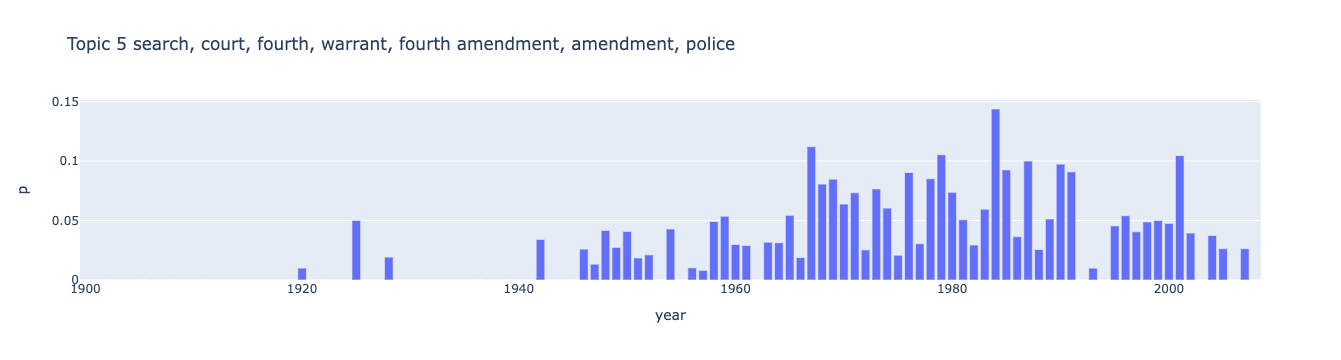

In [101]:
plot_topic_over_years(5)

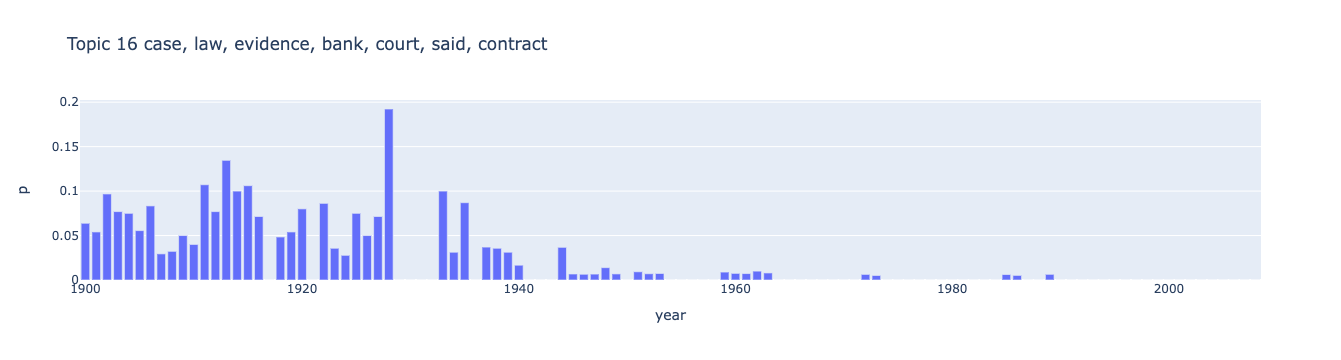

In [102]:
plot_topic_over_years(16)

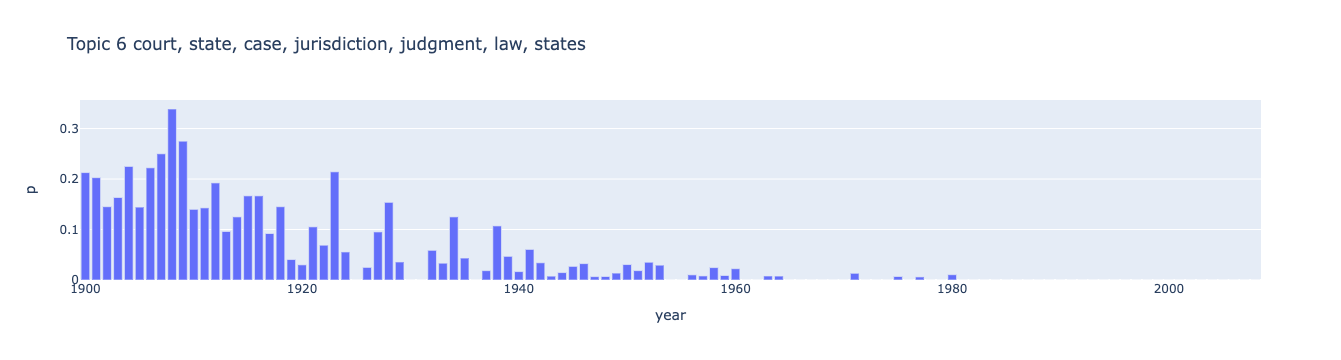

In [103]:
plot_topic_over_years(6)

## Dispersion Plots

In [104]:
X8.head()

year  topic_id  n     type
0  1789         0  0  opinion
1  1789         1  0  opinion
2  1789         2  0  opinion
3  1789         3  0  opinion
4  1789         4  0  opinion

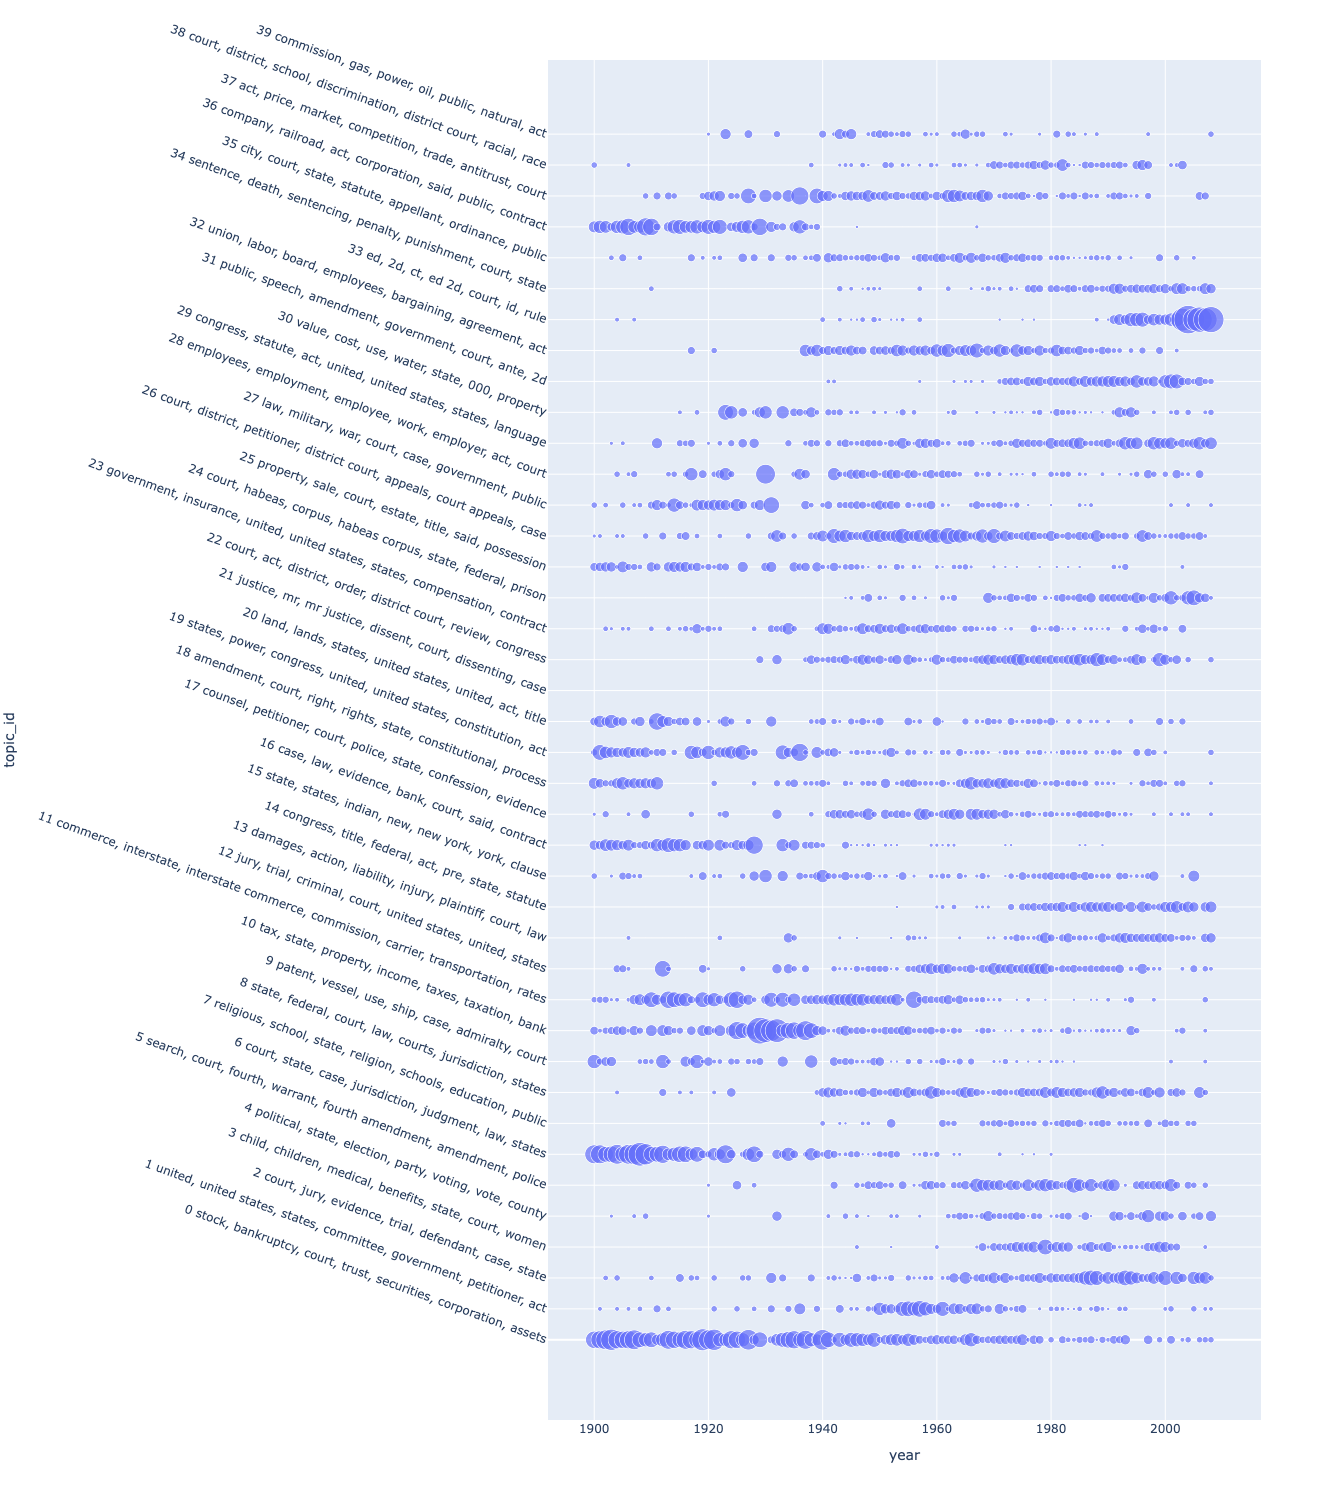

In [105]:
fig = px.scatter(X10[X10.year >= 1900], 'year', 'topic_id', size='p', height=1500)
fig.update_yaxes(tickmode='array', tickvals=db.TOPICS.index, ticktext = db.TOPICS.topwords.to_list(), tickangle=20)
fig.show()

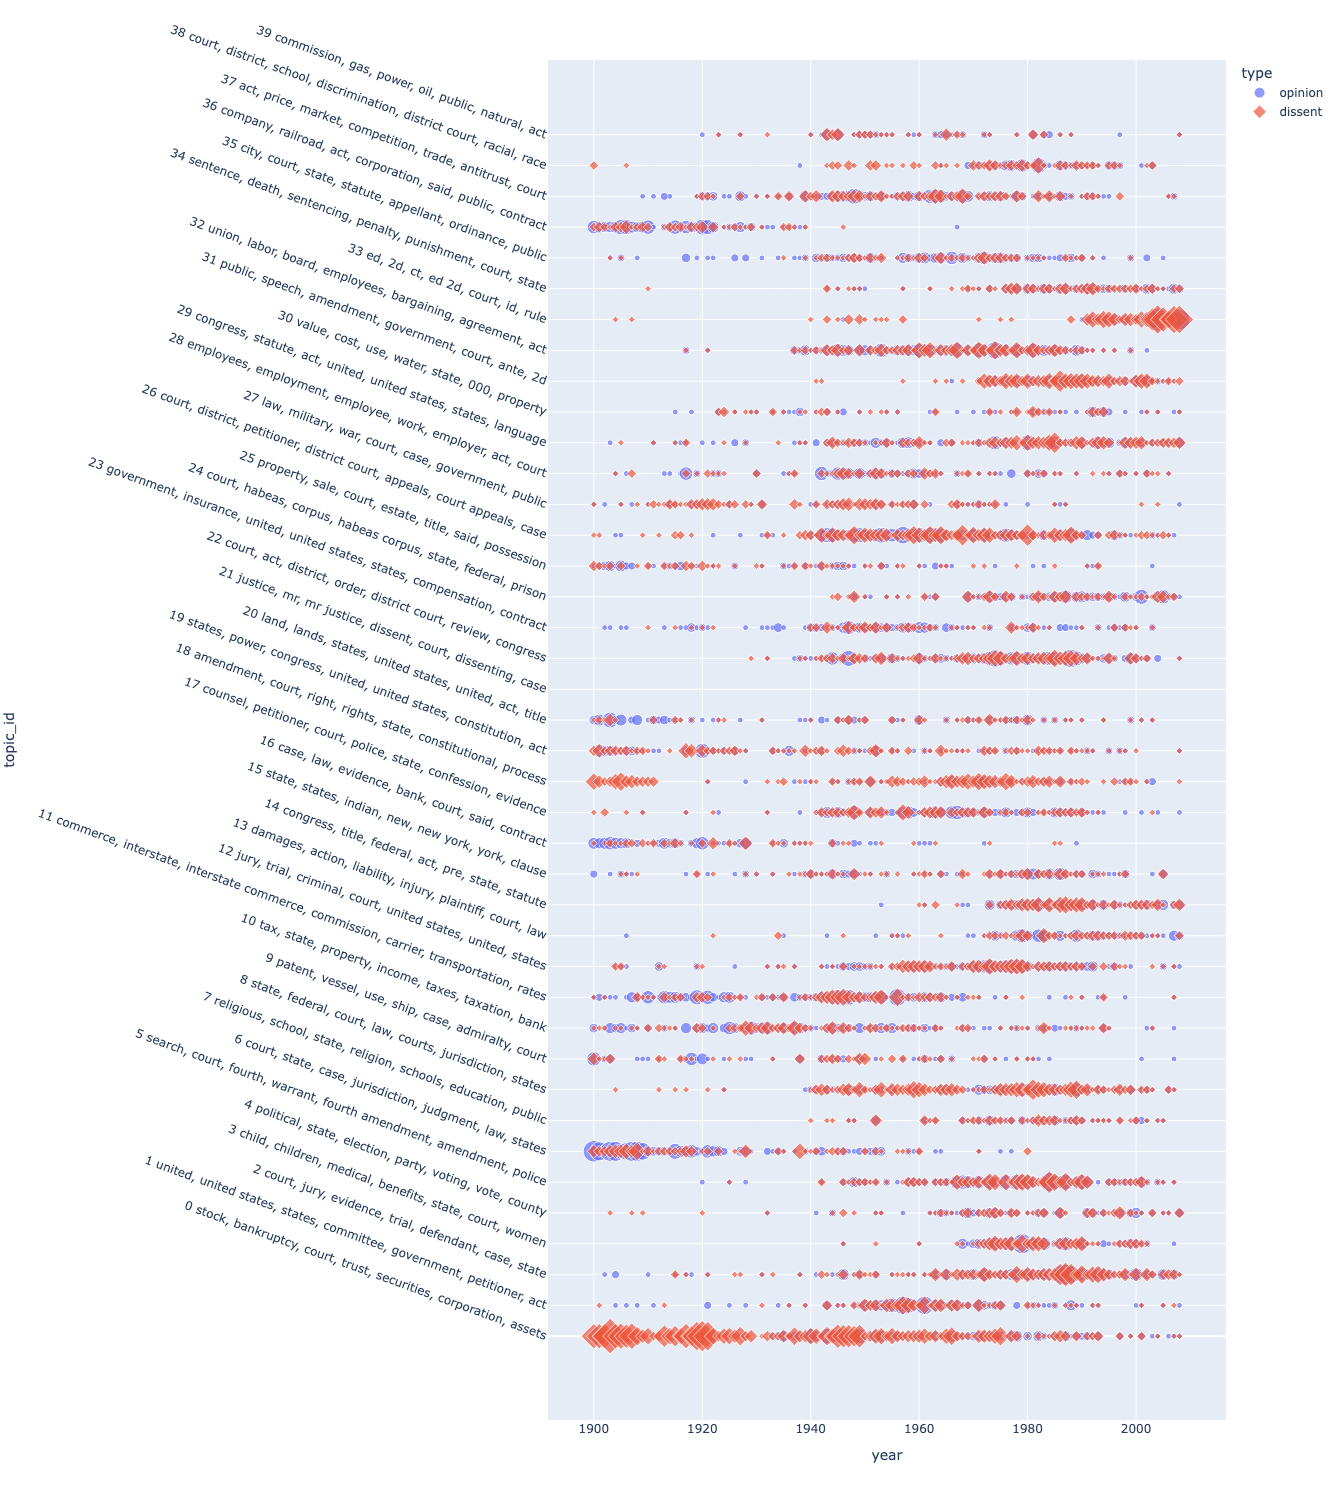

In [106]:
fig = px.scatter(X8[X8.year >= 1900], 'year', 'topic_id', color='type', symbol='type', size='n', height=1500)
fig.update_yaxes(tickmode='array', tickvals=db.TOPICS.index, ticktext = db.TOPICS.topwords.to_list(), tickangle=20)
fig.show()

In [67]:
# X4[['opinion_topic','dissent_topic']].plot(style=['+','x'], figsize=(30,15), alpha=.5);

In [68]:
# X4.loc[554][['opinion_topic','dissent_topic']].plot(style=['+','x'], figsize=(30,15))

In [69]:
# X4.xs(key=1973, level=2)[['opinion_topic','dissent_topic']].plot(style=['+','x'], figsize=(30,15))